## Purpose: simple problem with correlated errors in both x and y.

In problems with correlated errors in xdata and ydata the positions of all the xdata need to be optimized too. So we have an extra set of parameters that not actually are part of the model to be fitted. These kind of parameters are called nuisance parameters. 

These kind of problems can be solved with NestedSampler using the ErrorsInXandYProblem in stead of the default ClassicProblem.


Demonstration: 
1. Linear Model of artificial data
2. Parameter fit with correlated errors in x and y

Author: Do Kester


Import classes

In [1]:
import numpy as numpy
import math

from BayesicFitting import PolynomialModel

from BayesicFitting import NestedSampler
from BayesicFitting import ErrorsInXandYProblem
from BayesicFitting import GaussPrior
from BayesicFitting import UniformPrior
from BayesicFitting import LaplacePrior
from BayesicFitting import Tools
from BayesicFitting import formatter as fmt
from BayesicFitting import plotFit
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#%matplotlib osx

Define the constants of the linear relation. 

In [2]:
# define some constants
N = 21
b0 = 2            # offset of background
b1 = -1.6            # slope of background
b2 = 0.1

numpy.random.seed( 804091 )
sigx = numpy.zeros( N, dtype=float ) + 0.5
sigy = numpy.zeros( N, dtype=float ) + 0.5
sigz = numpy.append( numpy.linspace( 0.5, 0, N//2 + 1 ), numpy.linspace( -0.05, -0.5, N//2 ) )
sigz = numpy.zeros( N, dtype=float ) + 0.5

sigx = numpy.random.rand( N ) * 0.2 + 0.3
sigy = numpy.random.rand( N ) * 0.3 + 0.2
sigz = numpy.random.rand( N ) * 0.8 - 0.4
#print( fmt( sigz, max=None ) )
#sigz = numpy.asarray( [5,4,3,2,1,0,-1,-2,-3,-4,-5] ) * 0.1
cov = numpy.zeros( (N,2,2),dtype=float )
sz2 = sigz * sigz
cov[:,0,0] = sigy * sigy + sz2
cov[:,1,1] = sigx * sigx + sz2
cov[:,1,0] = sigz * sigx * sigy
cov[:,0,1] = cov[:,1,0]
det = cov[:,0,0] * cov[:,1,1] - cov[:,0,1] * cov[:,1,0]
print( fmt( det ) )
print( fmt( cov ) )


[    0.030    0.039    0.028    0.043    0.065 ...]
[[[    0.115   -0.021]
  [   -0.021    0.262]]
 [[    0.240    0.000]
  [    0.000    0.163]]
 [[    0.221   -0.011]
  [   -0.011    0.127]]
 [[    0.135    0.031]
  [    0.031    0.322]]
 [[    0.324    0.048]
  [    0.048    0.208]]
   ...]


Make a 2nd-degree polynomial

0.17712198437474777
0.158523563593603
0.06907972437567411
0.032697094364928285


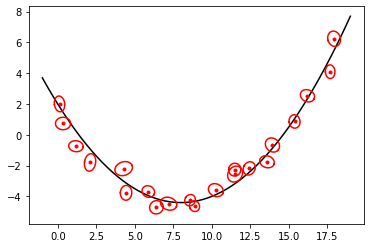

In [3]:
xm = numpy.linspace( 0.0, 18.0, N, dtype=float )
ym = b0 + b1 * xm + b2 * xm * xm


zer = numpy.random.randn( N ) * sigz
xer = numpy.random.randn( N ) * sigx + zer
yer = numpy.random.randn( N ) * sigy + zer

y = ym + xer
x = xm + yer

xx = numpy.linspace( -1, 19, 101, dtype=float )
yy = b0 + b1 * xx + b2 * xx * xx
plt.plot( xx, yy, 'k-' )
plt.plot( x, y, 'r.' )

v, w = numpy.linalg.eig( cov )
rv = numpy.sqrt( v )

tt = numpy.linspace( 0, 2 * math.pi, 91 )
ell = []
for k in range( N ) :
    el = numpy.append( rv[k,0] * numpy.cos( tt ), rv[k,1] * numpy.sin( tt ) ).reshape( 2, -1 ).T
    el = numpy.inner( el, w[k,:] )
    ell += [el]
    #plt.plot( 3 + xer, 1 + yer, 'g.' )
    plt.plot( x[k] + el[:,0], y[k] + el[:,1], 'r-' )

print( numpy.sum( xer * xer ) / N )
print( numpy.sum( yer * yer ) / N )
print( numpy.sum( xer * yer ) / N )
print( numpy.sum( zer * zer ) / N )
plt.axis( "equal" )
plt.show()

Define the model and define the limits on the model parameters

In [4]:
mdl = PolynomialModel( 2 )
mdl.setLimits( -10, 10 )


We need to set a specific Problem in this case: ErrorsInXandYProblem. It adds N extra parameters to the list, one for each datapoint present. These extra (nuisance) parameters need Priors. The same Prior for all, but centered on each of the x-points. 
[Gull (1989)](https://bayes.wustl.edu/sfg/line.pdf) argues for a Gaussian prior with a sigma about the same size as in the error distribution. 


The ErrorsInXandYProblem automatically enlists both the GalileanEngine and the GibbsEngine. The latter might be more efficient in moving the extra parameters around. They are all independent of each other and GibbsEngine tries to move the parameters one at a time.

In [5]:
#prior = LaplacePrior(  )
prior = UniformPrior( limits=[-3,3] )
problem = ErrorsInXandYProblem( mdl, x, y, covar=cov, prior=prior )
Tools.printclass( problem )

+++++++++++++++++++++++++++++++++++++++++++++++++++++++
ErrorsInXandYProblem of Polynomial: f( x:p ) = p_0 + p_1 * x + p_2 * x^2
+++++++++++++++++++++++++++++++++++++++++++++++++++++++
accuracy        None
determinant     [0.03  0.039 0.028 0.043 ... 0.024 0.033 0.019 0.042] 21
hasAccuracy     True
model           Polynomial
npars           24
partype         <class 'float'>
prior           UniformPrior with limits between -3.00 and 3.00
varxx           [0.262 0.163 0.127 0.322 ... 0.189 0.16  0.195 0.247] 21
varxy           [-2.065e-02  2.562e-05 -1.073e-02  3.130e-02 ... -8.124e-03 -2.937e-02
 -3.551e-03 -2.536e-02] 21
varyy           [0.115 0.24  0.221 0.135 ... 0.126 0.213 0.096 0.173] 21
weights         None
xdata           [ 0.115  0.342  1.181  2.098 ... 15.376 16.215 17.69  17.947] 21
ydata           [ 2.008  0.735 -0.74  -1.794 ...  0.867  2.536  4.099  6.237] 21


Invoke the NestedSampler with the problem just instantiated. The limits in the initialisation of NS are passed to the (Jeffreys)Prior of the scale hyperparameter in the (Gauss)Errordistribution. 
We want to do an extra long run as at the default end (=2.0) the information, H, is not yet completely stabilised.

In [6]:
ns = NestedSampler( problem=problem )
ns.verbose = 2
ns.distribution.setLimits( [0.1,1.0] )
# extra long run.
#ns.end = 10.0

# find the solution
evid = ns.sample( )


Fit all parameters of
  Polynomial: f( x:p ) = p_0 + p_1 * x + p_2 * x^2
Using a Gauss2d error distribution with unknown scale
Moving the walkers with   GalileanEngine  GibbsEngine  ChordEngine
Iteration     logZ        H       LowL     npar parameters                                   scale
       0  -1.46e+08      4.6  -1.46e+08     25  [   -8.667   -9.649   -8.621    0.561 ...    0.119]
     100  -6.90e+06      5.6  -6.90e+06     25  [    0.867    8.243    1.818   -1.605 ...    0.189]
     200  -1.25e+06      6.6  -1.25e+06     25  [    3.974   -4.742    2.227    1.482 ...    0.716]
     300  -1.61e+05      7.6  -1.61e+05     25  [   -1.674    8.306   -1.063   -1.109 ...    0.576]
     400  -2.66e+04      8.6  -2.66e+04     25  [    3.163   -7.983    0.521   -2.360 ...    0.162]
     500  -9.85e+03      8.9  -9.84e+03     25  [    3.650    2.640   -0.065   -0.926 ...    0.626]
     600  -3.86e+03     10.6  -3.85e+03     25  [    0.558   -3.654    0.208   -0.703 ...    0.177]
     70

In [7]:
pars = ns.parameters
print( "Parameters :", fmt( pars, max=None ) )
print( "StDevs     :", fmt( ns.stdevs, max=10 ) )
xopt = ns.samples.nuisance
print( "xdata      :", fmt( x, max=10))
print( "Nuisance   :", fmt( xopt, max=10 ) )
print( "StdevNuis  :", fmt( ns.samples.stdevNuis, max=10 ))
print( "Scale      :", fmt( ns.scale ) )

xml = ns.samples[-1].nuisance
pml = ns.samples[-1].parameters
print( "MLpar      :", fmt( pml ) )
print( "MLnuis     :", fmt( xml, max=10 ) )

Parameters : [    1.224   -1.429    0.092]
StDevs     : [    0.358    0.081    0.005]
xdata      : [    0.115    0.342    1.181    2.098    4.280    4.436    5.881    6.408    7.199    8.593 ...]
Nuisance   : [   -0.418    0.331    1.362    2.406    3.888    4.743    5.823    6.574    7.204    8.582 ...]
StdevNuis  : [    0.332    0.337    0.332    0.362    0.445    0.438    0.430    0.469    0.475    0.444 ...]
Scale      :     0.198
MLpar      : [    1.129   -1.442    0.093]
MLnuis     : [   -0.582    0.533    1.201    2.389    4.052    4.821    6.016    6.818    6.932    8.530 ...]


Plot the line and the connections of the datapoints to their targets.
Note that the axes are scaled to the same size to show that the distances are perpendicular (more or less).

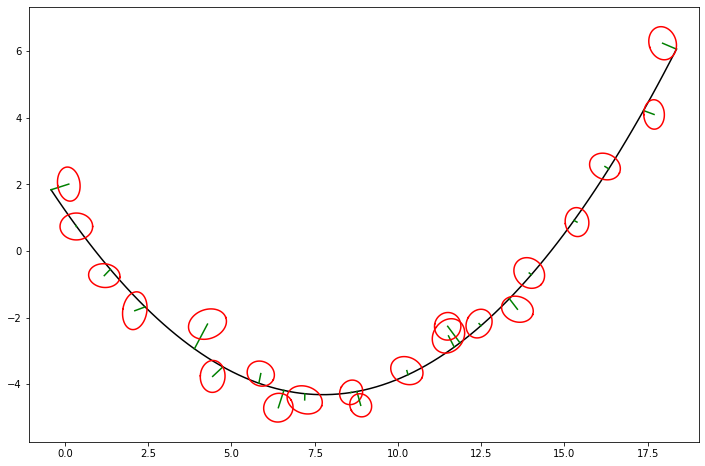

In [8]:
xx = numpy.linspace( min(xopt), max(xopt), 101 )

yfit = mdl.result( xx, pars )
plt.figure( "Errors in X and Y", figsize=(12,8) )

plt.plot( xx, yfit, 'k-' )
yopt = mdl.result( xopt, pars )
#plt.plot( xopt, yopt, 'k-' )
for k in range( N ):
    plt.plot( [x[k],xopt[k]], [y[k],yopt[k]], 'g-')
    plt.plot( x[k] + ell[k][:,0], y[k] + ell[k][:,1], 'r-' )
plt.axis( "equal" )
    
plt.show()

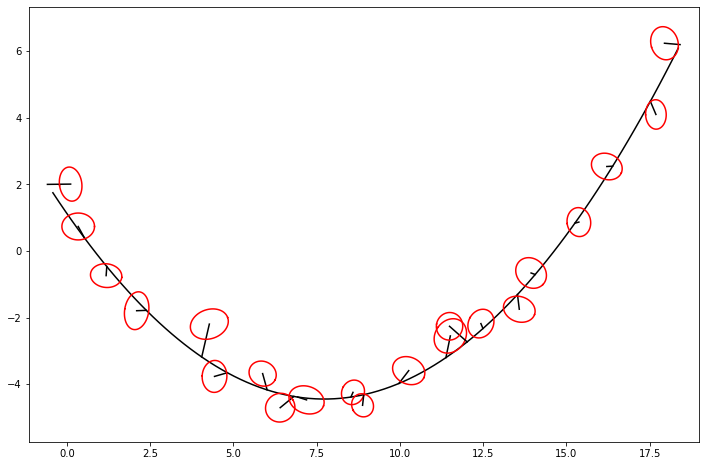

In [9]:
## MaxLikelihood solution
xx = numpy.linspace( min(xopt), max(xopt), 101 )

yfml = mdl.result( xx, pml )
plt.figure( "Errors in X and Y (ML)", figsize=(12,8) )

plt.plot( xx, yfml, 'k-' )
yml = mdl.result( xml, pml )

for k in range( N ):
    plt.plot( [x[k],xml[k]], [y[k], yml[k]], 'k-')
    plt.plot( x[k] + ell[k][:,0], y[k] + ell[k][:,1], 'r-' )
plt.axis( "equal" )
    
plt.show()